# Cancer Cell Segmentation
---

# Objective
This Notebook will cover these practices on a cell/brain masked dataset :
- Segmentation of the cancerous cells or different sections of a tumour using the good old UNet architecture


---


# Setup



In [ ]:
import torch
torch.manual_seed(2024)

In [ ]:
!pip install opencv-python --quiet
!pip install numba --quiet
!pip install tifffile --quiet
!pip install -q kaggle

In [ ]:
# Imports
import os
import cv2
import tqdm
import hashlib
import requests
import re
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split


from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

In [ ]:
# Helper functions
# By gemini
# prompt: write a helper function "im_show" to show images that are in format of tensor

def im_show(image, ax=None, figsize=(8, 8)):
  """Imshow for Tensor."""
  if ax is None:
    fig, ax = plt.subplots(figsize=figsize)
  # Handle 1-channel image
  if image.ndim == 2:
    image = image[..., None]
  ax.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
  ax.axis("off")
  return ax


# Getting the data
running this section once is enough since it's used to load data from kaggle

In [ ]:
!mkdir ./kaggle
!cp kaggle.json ./kaggle/
!chmod 600 ./kaggle/kaggle.json
!kaggle datasets download -d 'aryashah2k/breast-ultrasound-images-dataset'
!unzip breast-ultrasound-images-dataset.zip -d ./data

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access './kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
100% 194M/195M [00:11<00:00, 22.8MB/s]
100% 195M/195M [00:11<00:00, 18.1MB/s]
Archive:  breast-ultrasound-images-dataset.zip
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: .

# Loading the data
Since the image and the mask of the image is needed in the data segmentation process we had to write an specific dataset class for our data
Also an image can have more than one mask. In that case the masks have to be added into one mask image

In [ ]:

# part of this cell is generated by gemini
class BUSIDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.mask_paths = []
    for dirpath, _, filenames in os.walk(self.root_dir):
      for filename in filenames:
        if filename.endswith('.png'):
          if '_mask.png' in filename:
            self.mask_paths.append(os.path.join(dirpath, filename))
    self.mask_paths = sorted(self.mask_paths)

  def __len__(self):
    return len(self.mask_paths)

  def __getitem__(self, idx,):
    image =  cv2.imread(self.mask_paths[idx].replace('_mask', ''))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(self.mask_paths[idx])
    mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    #we might have more than one mask. in that case we gotto add em up
    if os.path.exists(self.mask_paths[idx].replace('_mask', '_mask_1')):
        mask_1 = cv2.imread(self.mask_paths[idx].replace('_mask', '_mask_1'))
        mask_1 = cv2.cvtColor(mask_1,cv2.COLOR_BGR2GRAY)
        mask += mask_1
    if os.path.exists(self.mask_paths[idx].replace('_mask', '_mask_2')):
        mask_2 = cv2.imread(self.mask_paths[idx].replace('_mask', '_mask_2'))
        mask_2 = cv2.cvtColor(mask_2,cv2.COLOR_BGR2GRAY)
        mask += mask_2

    if self.transform:
      image = self.transform(Image.fromarray(image))
      mask = self.transform(Image.fromarray(mask))

    return image, mask


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Dataset size : 780


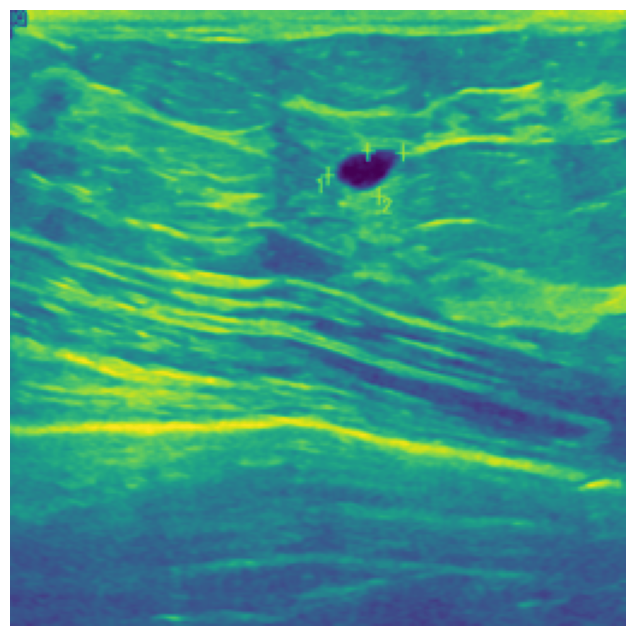

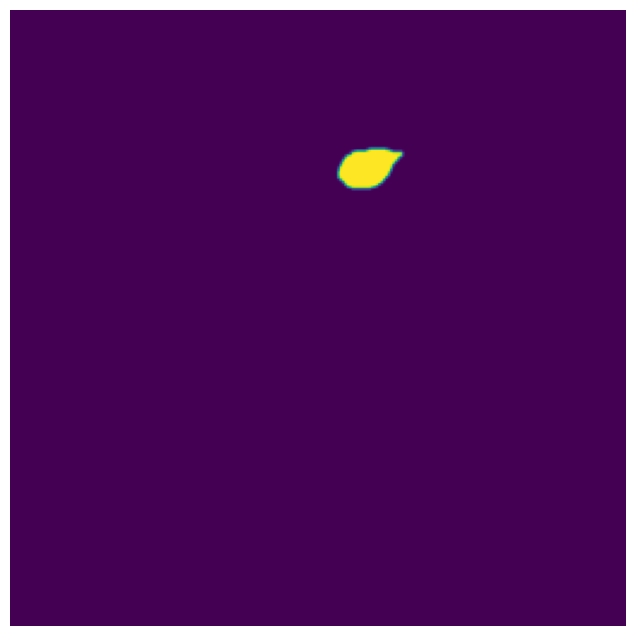

In [ ]:
# this transform instance resizes the width and height to make sure all the data is in one shape
# then it converts to tensor
# and finally normalizes the output
transform = transforms.Compose([transforms.Resize(size= (256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.5], std = [0.2])])
dataset = BUSIDataset('./data/Dataset_BUSI_with_GT',transform = transform)
image, mask = dataset[12]
print(image.shape, mask.shape)
im_show(image)
im_show(mask)

img_all = [dataset[i][0] for i in range(len(dataset))]
msk_all = [dataset[i][1] for i in range(len(dataset))]

print(f"Dataset size : {len(dataset)}")

#WE SURELY LACK ENOUGH DATA
#NEED SOME DATA AUGMENTATION TECHNIQUES


#Data Augmentation

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 256, 256])


<Axes: >

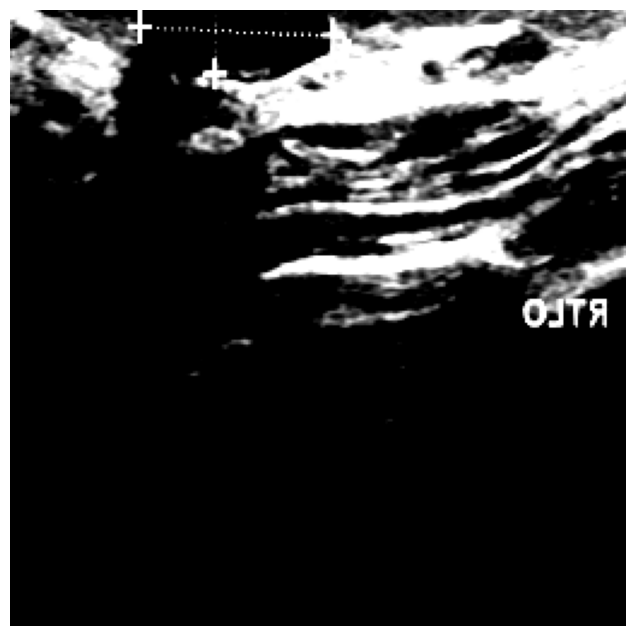

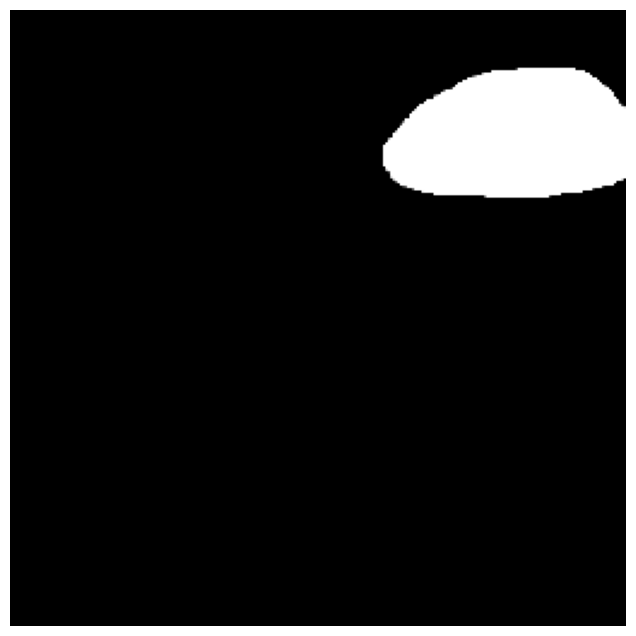

In [ ]:
aug_trf = v2.Compose([
    v2.RandomResizedCrop(size = (256,256),antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32,scale=True),
    v2.ToTensor(),
    v2.Normalize([0.5,0.5,0.5],[0.2,0.2,0.2])
])
aug_data = BUSIDataset('./data/Dataset_BUSI_with_GT',transform=aug_trf)
image,mask = aug_data[122]
print(image.shape)
im_show(image)
im_show(mask)

#Spliting Data

In [ ]:
seed = 42
train_ratio= 0.7
#create a generator object
gen = torch.Generator().manual_seed(42)
train_ds,val_ds = random_split(dataset,[train_ratio,(1 - train_ratio)])
img_train = torch.stack([train_ds[i][0] for i in range(len(train_ds))])
mask_train = torch.stack([train_ds[i][1] for i in range(len(train_ds))])
img_val = torch.stack([val_ds[i][0] for i in range(len(val_ds))])
mask_val = torch.stack([val_ds[i][1] for i in range(len(val_ds))])


In [ ]:
print(mask_train.shape)

torch.Size([546, 1, 256, 256])


In [ ]:
#LABELS :
labels_train = np.zeros((len(mask_train), 2,
                         mask_train.shape[-2],
                         mask_train.shape[-1]),
                        np.longlong)
print(labels_train.shape)
print((mask_train == 0 ).shape)
print(labels_train[:,0].shape)
labels_train[:, 0] = torch.squeeze(mask_train == 0)
labels_train[:, 1] = torch.squeeze(mask_train > 0)

labels_val = np.zeros((len(mask_val), 2,
                        mask_val.shape[-2],
                        mask_val.shape[-1]),
                       np.longlong)
labels_val[:, 0] = torch.squeeze(mask_val == 0)
labels_val[:, 1] = torch.squeeze(mask_val > 0)

(546, 2, 256, 256)
torch.Size([546, 1, 256, 256])
(546, 256, 256)


#U-net Architecture
Why U-net for biomedical Data :

1. Most of the time, in medical imaging, we do not have sufficient samples to train. Previous semantic segmentation architectures did not perform very well when trained on insufficient medical imaging samples (adapted from [here](https://debuggercafe.com/unet-from-scratch-using-pytorch/))


the cells in this section are adapted from the template

In [ ]:
import torch
import torch.nn.functional as F


def pad_to(x, stride):
    h, w = x.shape[-2:]

    if h % stride > 0:
        new_h = h + stride - h % stride
    else:
        new_h = h
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w
    lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
    lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
    pads = (lw, uw, lh, uh)

    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    out = F.pad(x, pads, "constant", 0)

    return out, pads

def unpad(x, pad):
    if pad[2]+pad[3] > 0:
        x = x[:,:,pad[2]:-pad[3],:]
    if pad[0]+pad[1] > 0:
        x = x[:,:,:,pad[0]:-pad[1]]
    return x

KeyboardInterrupt: 

In [ ]:
# # adapted from the template
# # should change it later

# def convbatchrelu(in_channels, out_channels, sz):
#   return nn.Sequential(
#       nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
#       nn.BatchNorm2d(out_channels, eps=1e-5),
#       nn.ReLU(inplace=True),
#       )


# class convdown(nn.Module):
#   def __init__(self, in_channels, out_channels, kernel_size):
#     super().__init__()
#     self.conv = nn.Sequential()
#     for t in range(2):
#       if t == 0:
#         self.conv.add_module('conv_%d'%t,
#                              convbatchrelu(in_channels,
#                                            out_channels,
#                                            kernel_size))
#       else:
#         self.conv.add_module('conv_%d'%t,
#                              convbatchrelu(out_channels,
#                                            out_channels,
#                                            kernel_size))

#   def forward(self, x):
#     x = self.conv[0](x)
#     x = self.conv[1](x)
#     return x


# class downsample(nn.Module):
#   def __init__(self, nbase, kernel_size):
#     super().__init__()
#     self.down = nn.Sequential()
#     self.maxpool = nn.MaxPool2d(3, 3)
#     for n in range(len(nbase) - 1):
#       self.down.add_module('conv_down_%d'%n,
#                            convdown(nbase[n],
#                                     nbase[n + 1],
#                                     kernel_size))

#   def forward(self, x):
#     xd = []
#     for n in range(len(self.down)):
#       if n > 0:
#         y = self.maxpool(xd[n - 1])
#       else:
#         y = x
#       xd.append(self.down[n](y))
#     return xd


# class convup(nn.Module):
#   def __init__(self, in_channels, out_channels, kernel_size):
#     super().__init__()
#     self.conv = [
#             nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
#             nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)]
#     self.conv = nn.ModuleList(self.conv)
#     self.relu = nn.ReLU()

#   def forward(self, x, y):
#     diff = y.size(3) - x.size(3)
#     x = F.pad(x, (diff // 2, diff - diff // 2, diff // 2, diff - diff // 2))  # Pad spatial dimensions

#     # Check if channel dimensions match, pad if necessary
#     diff = y.size(1) - x.size(1)
#     if diff > 0:
#       x = F.pad(x, (0, 0, 0, 0, 0, diff))  # Pad the channel dimension
#     x = self.conv[0](x + y)  # Now shapes should match
#     x = self.relu(x)
#     x = self.conv[1](x)
#     return x


# class upsample(nn.Module):
#   def __init__(self, nbase, kernel_size):
#     super().__init__()
#     self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
#     self.up = nn.Sequential()
#     for n in range(len(nbase) - 1 , 0, -1):
#       self.up.add_module('conv_up_%d'%(n ),
#               convup(nbase[n], nbase[n -1], kernel_size))

#   def forward(self, xd):
#     x = xd[-1]
#     for n in range(0, len(self.up)):
#       if n > 0:
#         x = self.upsampling(x)
#       x = self.up[n](x, xd[len(xd) -1 - n])
#     return x


# class Unet(nn.Module):
#   def __init__(self, nbase, nout, kernel_size):
#     super(Unet, self).__init__()
#     self.nbase = nbase
#     self.nout = nout
#     self.kernel_size = kernel_size
#     self.downsample = downsample(nbase, kernel_size)
#     nbaseup = nbase[1:]
#     nbaseup.append(nbase[-1])
#     self.upsample = upsample(nbaseup, kernel_size)
#     self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
#                             padding=kernel_size//2)


#   def forward(self, data):
#     data,pads = pad_to(data,32)
#     T0 = self.downsample(data)
#     T0 = self.upsample(T0)
#     #unpad after upsampling
#     T0 = unpad(T0,pads)
#     T0 = self.output(T0)
#     return T0

#   def save_model(self, filename):
#     torch.save(self.state_dict(), filename)

#   def load_model(self, filename, cpu=False):
#     if not cpu:
#       self.load_state_dict(torch.load(filename))
#     else:
#       self.__init__(self.nbase,
#                     self.nout,
#                     self.kernel_size,
#                     self.concatenation)

#       self.load_state_dict(torch.load(filename,
#                                       map_location=torch.device('cpu')))

In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
""" Full assembly of the parts to form the complete network """


class UNet(nn.Module):
    def __init__(self, n_channels, n_out, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_out = n_out
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64 // factor, bilinear))
        self.outc = (OutConv(64, n_out))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x,x1)
        logits = self.outc(x)
        return logits
    def save_model(self, filename):
        torch.save(self.state_dict(), filename)

    def load_model(self, filename, cpu=False):
        if not cpu:
          self.load_state_dict(torch.load(filename))
        else:
          self.__init__(self.nbase,
                        self.nout,
                        self.kernel_size,
                        self.concatenation)

          self.load_state_dict(torch.load(filename,
                                          map_location=torch.device('cpu')))

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
import os
import torch
import gc


kernel_size = 3
# nbase = [1, 16,32,64]  # number of channels per layer
first_channel = 1
nout = 3  # number of outputs

net = UNet(first_channel, nout)

# Try a smaller model if memory is an issue
# nbase = [1, 16, 32, 64]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

try:
    net.to(device)
    print("Model successfully moved to GPU.")
except RuntimeError as e:
    print(f"Error moving model to GPU: {e}")
    # If the error persists, consider reducing model size or using a CPU
    device = torch.device('cpu')
    net.to(device)
    print("Model moved to CPU due to memory constraints.")

!nvidia-smi  # Check GPU memory usage again

#Training the U-net

In [ ]:
#Hyperparameters :
batch_size = 8
#Since we got enough data too big value for n_epochs wouldn't make much of difference
n_epochs = 30
learn_rate = 1e-2
#For L2 regularization :
weight_decay =1e-3
momentum = 0.9
n_epochs_per_save = 15


In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
print(img_train.shape)
print(labels_train.shape)

torch.Size([546, 1, 256, 256])
(546, 2, 256, 256)


In [ ]:

import gc
num_of_lrs = 10
n_train = len(img_train)
#optimizer :
optimizer = torch.optim.SGD(net.parameters(),
                            lr = learn_rate,
                            momentum = momentum,
                            weight_decay = weight_decay,
                            )
lrs = np.linspace(0,learn_rate,num_of_lrs)

#Just in case num ofepochs are more than 250 :
if n_epochs > 250:
    Lrs = np.append(lrs, learn_rate*np.ones(n_epochs-100))
    for i in range(num_of_lrs):
        lrs = np.append(lrs, lrs[-1]/2 * np.ones(num_of_lrs))
else:
    lrs = np.append(lrs, learn_rate * np.ones(max(0, n_epochs - num_of_lrs)))

loss_criterion = nn.CrossEntropyLoss()

#loss for each epoch :
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan

save_epoch = None

#looping over epochs :
for epoch in range(n_epochs):
  net.train()
  epoch_loss = 0
  iters =0
  for param_group in optimizer.param_groups :
    param_group['lr'] = lrs[epoch]
    img_lbl_dl = DataLoader(dataset = ConcatDataset(img_train,labels_train),batch_size = batch_size)
    img_lbl_it = iter(img_lbl_dl)
    with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='imgs') as pbar:

      for ith_batch in np.arange(0,n_train,batch_size):
        #Augmentation
        #left to be done
        img,lbl = next(img_lbl_it)

        imgs = img.to(device = device)
        lbls = lbl.to(device = device)
        del img,lbl
        gc.collect()

        #compute the loss
        y = net(imgs)
        loss = loss_criterion(y,lbls[:,1])
        epoch_loss += loss.item()
        pbar.set_postfix(**{'loss (batch)': loss.item()})
        #gradient_descent
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        iters +=1
        pbar.update(imgs.shape[0])
      epoch_losses[epoch] = epoch_loss
      pbar.set_postfix(**{'loss (epoch)': epoch_loss})

  #Save stuff
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
net.save_model(f"unet_epoch{epoch+1}.pth")

Epoch 1/30: 100%|██████████| 546/546 [00:40<00:00, 13.63imgs/s, loss (epoch)=83.7]



Saving network state at epoch 1


Epoch 16/30: 100%|██████████| 546/546 [00:39<00:00, 13.71imgs/s, loss (epoch)=7.32]



Saving network state at epoch 16


Epoch 30/30: 100%|██████████| 546/546 [00:40<00:00, 13.64imgs/s, loss (epoch)=2.66]



Saving network state at epoch 30


#Evaluating model on validation set




torch.Size([256, 256])


Text(0.5, 1.0, 'real mask')

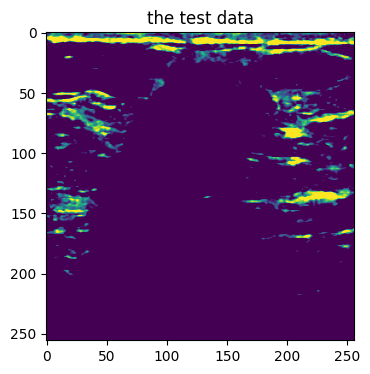

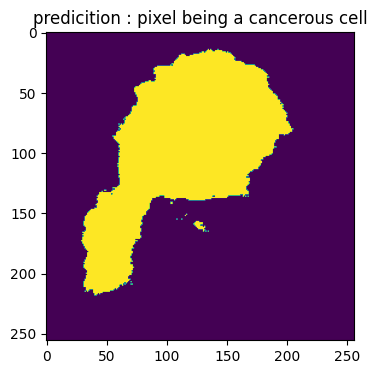

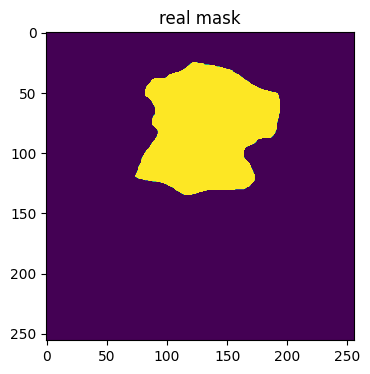

In [ ]:
net.eval()
i = 100
img_test,pads = pad_to(img_val[i],16)
img_test = img_test.to(device = device)

img_test = torch.unsqueeze(img_test,0)
out = torch.squeeze(net(img_test))
#first channel is the prob of every pixel being a tumourous cell
labels_is = out[1].detach().cpu()
print(labels_is.shape)
labels_f = torch.zeros_like(labels_is)
thrsh = 2.3
for x in range(len(labels_is)):
  for y in range(labels_is.shape[1]):
    if labels_is[x,y] >= thrsh:
      labels_f[x,y] = 1

plt.figure(figsize=(10, 4))
plt.imshow(img_test[0,0].cpu(), vmin=0, vmax=1)
plt.title('the test data')

plt.figure(figsize=(10, 4))
plt.imshow(labels_f, vmin=0, vmax=1)
plt.title('predicition : pixel being a cancerous cell')

plt.figure(figsize=(10, 4))
plt.imshow(mask_val[i,0].numpy(), vmin=0, vmax=1)
plt.title('real mask')




#Helper functions

In [ ]:
#Adopted from template
def get_masks_unet(output, cell_threshold=0, min_size=30):
  """ create masks using NOT CELL probability and CELL probability

  min_size: minimum number of pixels in the masks
  """

  cells = (output[1] - output[0]) > cell_threshold
  selem = generate_binary_structure(cells.ndim, connectivity=1)
  masks, nlabels = label(cells, selem)
  shape0 = masks.shape
  _,masks = np.unique(masks, return_inverse=True)
  masks = np.reshape(masks, shape0)
  # fill holes and remove small masks
  masks = fill_holes_and_remove_small_masks(masks, min_size=min_size)

  return masks.astype(np.uint16)



In [ ]:
net.eval()
# (depending on GPU capacity you may need to run this in a loop)
test_padded, pads = pad_to(imgs_test, 16)
test_torch = test_padded.to(device)
out = net(test_torch)
# compute CELL / NOT CELL probability
labels = out[].detach().cpu().numpy()

cell_threshold
# create masks from probabilities
masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels_is]

# (note this function expects multiple masks)
iou_threshold = np.arange(0.5, 1, 0.1)
ap = average_precision(masks_test, masks, threshold=iou_threshold)[0]

# plot results
print(ap[:,0].mean(axis=0))
plt.plot(iou_threshold, ap.mean(axis=0))
plt.xlabel('IoU threshold')
plt.ylabel('average precision')
plt.ylim([0, 1])
plt.show()